In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

# Check if GPU is available and set device to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available -> use CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define paths for datasets
# evaluation_dataset_path = '/content/drive/My Drive/IR Classification/Dataset/evaluation_dataset.csv'
# initial_labeling_dataset_path = '/content/drive/My Drive/IR Classification/Dataset/initial_labeling_dataset.csv'
# semi_supervised_dataset_path = '/content/drive/My Drive/IR Classification/Dataset/semi_supervised_dataset.csv'
evaluation_dataset_path = './evaluation_dataset.csv'
initial_labeling_dataset_path = './initial_labeling_dataset.csv'
semi_supervised_dataset_path = './semi_supervised_dataset.csv'

# Load datasets
df_evaluation_subjective = pd.read_csv(evaluation_dataset_path)
df_initial_labeling_subjective = pd.read_csv(initial_labeling_dataset_path)
df_semi_supervised_subjective = pd.read_csv(semi_supervised_dataset_path)

In [ ]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, dataloader, optimizer):
    """Train the model on training data."""
    model.train()  # Set model to training mode
    total_train_loss = 0

    # Iterate over batches
    for batch in tqdm(dataloader, desc="Training"):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(**inputs)  # Forward pass
        loss = outputs[0]  # Get loss
        total_train_loss += loss.item()  # Accumulate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    # Compute average loss
    avg_train_loss = total_train_loss / len(dataloader)
    print(f"Average training loss: {avg_train_loss}")

def evaluate_model(model, dataloader):
    """Evaluate the model's performance on a dataset."""
    model.eval()  # Set model to evaluation mode
    total_eval_accuracy = 0
    all_preds = []
    all_labels = []

    # Iterate over batches
    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        with torch.no_grad():  # Disable gradient calculation
            outputs = model(**inputs)

        logits = outputs[1]
        preds = torch.argmax(logits, dim=1).flatten()  # Get predictions

        # Accumulate predictions and labels
        all_preds.extend(preds.tolist())
        all_labels.extend(inputs['labels'].flatten().tolist())

        # Calculate accuracy
        total_eval_accuracy += torch.sum(preds == inputs['labels'].flatten()).item()

    # Compute average accuracy
    avg_accuracy = total_eval_accuracy / len(dataloader.dataset)
    print(f"Accuracy: {avg_accuracy}")

    # Generate confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    report = classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive'], digits=4)
    print("\nClassification Report:")
    print(report)
    return cm, report

def prepare_dataloader(df, tokenizer, batch_size=32, max_length=256):
    """Creates a DataLoader for model training or evaluation."""
    # Fill missing text entries
    df['post_comment_processed'].fillna("", inplace=True)

    # Map sentiment labels to integers
    sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    labels = df['sentiment'].map(sentiment_mapping).values
    labels = torch.tensor(labels).long()

    # Tokenize text
    encoding = tokenizer(df['post_comment_processed'].tolist(),
                         add_special_tokens=True,
                         max_length=max_length,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt')

    # Create TensorDataset and DataLoader
    dataset = TensorDataset(encoding['input_ids'], encoding['attention_mask'], labels)
    dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

    return dataloader

def generate_pseudo_labels(model, data_loader, tokenizer, device, confidence_threshold=0.9):
    """Generates pseudo-labels for unlabeled data using the model."""
    model.eval()  # Set model to evaluation mode
    pseudo_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in tqdm(data_loader, desc="Pseudo-labeling"):
            # Move batch to device
            input_ids, attention_mask = batch[:2]
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

            # Model prediction
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            max_probs, preds = torch.max(probs, dim=1)

            # Select high-confidence predictions
            high_confidence_indices = max_probs > confidence_threshold
            high_confidence_texts = tokenizer.batch_decode(input_ids[high_confidence_indices], skip_special_tokens=True)
            high_confidence_labels = preds[high_confidence_indices].tolist()

            pseudo_labels.extend(zip(high_confidence_texts, high_confidence_labels))

    # Create DataFrame for pseudo-labeled data
    df_pseudo_labels = pd.DataFrame(pseudo_labels, columns=['post_comment_processed', 'sentiment'])
    df_pseudo_labels['sentiment'] = df_pseudo_labels['sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

    return df_pseudo_labels

def update_semi_supervised_dataset(original_df, pseudo_labeled_df):
    """Updates the dataset by removing pseudo-labeled examples."""
    return original_df[~original_df['post_comment_processed'].isin(pseudo_labeled_df['post_comment_processed'])]


In [ ]:
# Initialize XLNet model and tokenizer for sequence classification
tokenizer_xlnet = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model_xlnet = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3).to(device)

# Set up the optimizer with recommended settings
optimizer = AdamW(model_xlnet.parameters(), lr=5e-5, eps=1e-8)
epochs = 4  # Define the total number of training epochs

# Split initial labeling data for training and validation
df_train_initial, df_validation_initial = train_test_split(df_initial_labeling_subjective, test_size=0.2, random_state=42)

# Prepare dataloaders for initial training, validation, and evaluation
train_dataloader = prepare_dataloader(df_train_initial, tokenizer_xlnet, batch_size=16, max_length=128)
validation_dataloader = prepare_dataloader(df_validation_initial, tokenizer_xlnet, batch_size=16, max_length=128)
evaluation_dataloader = prepare_dataloader(df_evaluation_subjective, tokenizer_xlnet, batch_size=16, max_length=128)

# Initialize dataset for semi-supervised learning iterations
df_semi_supervised_current = df_semi_supervised_subjective.copy()

# Define dynamic threshold for pseudo-label generation
threshold = 0.90  # Initial threshold for pseudo-labeling
threshold_updates = {6: 0.88, 10: 0.85, 12: 0.8}  # Update thresholds based on iteration

# Semi-supervised learning loop
ssl_iterations = 14  # Set the total number of iterations for semi-supervised learning
for iteration in range(ssl_iterations):
    print(f"Iteration {iteration + 1}/{ssl_iterations}")

    # Adjust the threshold dynamically per iteration
    if iteration in threshold_updates:
        threshold = threshold_updates[iteration]

    # Prepare DataLoader for semi-supervised learning with the current dataset
    semi_supervised_data_loader = prepare_dataloader(df_semi_supervised_current, tokenizer_xlnet, batch_size=16, max_length=128)

    # Generate pseudo-labels and combine with the initial training data
    if iteration > 0:
        df_pseudo_labels = generate_pseudo_labels(model_xlnet, semi_supervised_data_loader, tokenizer_xlnet, device, threshold)
        combined_df = pd.concat([df_train_initial, df_pseudo_labels])  # Combine for retraining
        train_dataloader = prepare_dataloader(combined_df, tokenizer_xlnet, batch_size=16, max_length=128)

    # Recalculate the total steps for the learning rate scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Train and evaluate the model with the updated dataloader
    train_model(model_xlnet, train_dataloader, optimizer)
    evaluate_model(model_xlnet, validation_dataloader)

    # Update the dataset for the next iteration
    if iteration > 0:
        df_semi_supervised_current = update_semi_supervised_dataset(df_semi_supervised_current, df_pseudo_labels)

    # Print the remaining number of unlabeled datasets
    print(f"Remaining unlabeled data after iteration {iteration + 1}: {len(df_semi_supervised_current)}")

print("Semi-Supervised Learning completed.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iteration 1/14


Training:   0%|          | 0/214 [00:00<?, ?it/s]

Average training loss: 0.9344748512049702


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.6226635514018691

Classification Report:
              precision    recall  f1-score   support

    Negative     0.0000    0.0000    0.0000       216
     Neutral     0.4533    0.7786    0.5730       131
    Positive     0.6830    0.8468    0.7561       509

    accuracy                         0.6227       856
   macro avg     0.3788    0.5418    0.4431       856
weighted avg     0.4755    0.6227    0.5373       856

Remaining unlabeled data after iteration 1: 9978
Iteration 2/14


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pseudo-labeling:   0%|          | 0/624 [00:00<?, ?it/s]

Training:   0%|          | 0/214 [00:00<?, ?it/s]

Average training loss: 0.7818774711862903


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.6869158878504673

Classification Report:
              precision    recall  f1-score   support

    Negative     0.4667    0.4537    0.4601       216
     Neutral     0.8293    0.5191    0.6385       131
    Positive     0.7482    0.8291    0.7866       509

    accuracy                         0.6869       856
   macro avg     0.6814    0.6006    0.6284       856
weighted avg     0.6896    0.6869    0.6815       856

Remaining unlabeled data after iteration 2: 9978
Iteration 3/14


Pseudo-labeling:   0%|          | 0/624 [00:00<?, ?it/s]

Training:   0%|          | 0/520 [00:00<?, ?it/s]

Average training loss: 0.3411380107084719


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.6892523364485982

Classification Report:
              precision    recall  f1-score   support

    Negative     0.4159    0.2176    0.2857       216
     Neutral     0.8000    0.6107    0.6926       131
    Positive     0.7201    0.9096    0.8038       509

    accuracy                         0.6893       856
   macro avg     0.6453    0.5793    0.5941       856
weighted avg     0.6556    0.6893    0.6561       856

Remaining unlabeled data after iteration 3: 5609
Iteration 4/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/351 [00:00<?, ?it/s]

Training:   0%|          | 0/287 [00:00<?, ?it/s]

Average training loss: 0.3925308044285932


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.772196261682243

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6215    0.6157    0.6186       216
     Neutral     0.8051    0.7252    0.7631       131
    Positive     0.8263    0.8507    0.8383       509

    accuracy                         0.7722       856
   macro avg     0.7510    0.7305    0.7400       856
weighted avg     0.7714    0.7722    0.7714       856

Remaining unlabeled data after iteration 4: 4955
Iteration 5/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/310 [00:00<?, ?it/s]

Training:   0%|          | 0/294 [00:00<?, ?it/s]

Average training loss: 0.2988117516965789


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7932242990654206

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6510    0.7685    0.7049       216
     Neutral     0.7903    0.7481    0.7686       131
    Positive     0.8700    0.8153    0.8418       509

    accuracy                         0.7932       856
   macro avg     0.7704    0.7773    0.7718       856
weighted avg     0.8026    0.7932    0.7960       856

Remaining unlabeled data after iteration 5: 4188
Iteration 6/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/262 [00:00<?, ?it/s]

Training:   0%|          | 0/346 [00:00<?, ?it/s]

Average training loss: 0.24194082246576518


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7745327102803738

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6645    0.4676    0.5489       216
     Neutral     0.8167    0.7481    0.7809       131
    Positive     0.7945    0.9116    0.8490       509

    accuracy                         0.7745       856
   macro avg     0.7586    0.7091    0.7263       856
weighted avg     0.7651    0.7745    0.7629       856

Remaining unlabeled data after iteration 6: 2677
Iteration 7/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/168 [00:00<?, ?it/s]

Training:   0%|          | 0/236 [00:00<?, ?it/s]

Average training loss: 0.26067694694877175


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8014018691588785

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7607    0.5741    0.6544       216
     Neutral     0.7215    0.8702    0.7889       131
    Positive     0.8374    0.8802    0.8582       509

    accuracy                         0.8014       856
   macro avg     0.7732    0.7748    0.7672       856
weighted avg     0.8003    0.8014    0.7962       856

Remaining unlabeled data after iteration 7: 2359
Iteration 8/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/148 [00:00<?, ?it/s]

Training:   0%|          | 0/301 [00:00<?, ?it/s]

Average training loss: 0.1850426645757649


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7827102803738317

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7869    0.4444    0.5680       216
     Neutral     0.7211    0.8092    0.7626       131
    Positive     0.7973    0.9194    0.8540       509

    accuracy                         0.7827       856
   macro avg     0.7684    0.7244    0.7282       856
weighted avg     0.7830    0.7827    0.7679       856

Remaining unlabeled data after iteration 8: 1678
Iteration 9/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/105 [00:00<?, ?it/s]

Training:   0%|          | 0/289 [00:00<?, ?it/s]

Average training loss: 0.19089531250117558


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7838785046728972

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7869    0.4444    0.5680       216
     Neutral     0.7500    0.8015    0.7749       131
    Positive     0.7912    0.9234    0.8522       509

    accuracy                         0.7839       856
   macro avg     0.7760    0.7231    0.7317       856
weighted avg     0.7838    0.7839    0.7687       856

Remaining unlabeled data after iteration 9: 1278
Iteration 10/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/80 [00:00<?, ?it/s]

Training:   0%|          | 0/278 [00:00<?, ?it/s]

Average training loss: 0.1726514666086639


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8002336448598131

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7394    0.5648    0.6404       216
     Neutral     0.8250    0.7557    0.7888       131
    Positive     0.8126    0.9116    0.8593       509

    accuracy                         0.8002       856
   macro avg     0.7923    0.7440    0.7628       856
weighted avg     0.7960    0.8002    0.7933       856

Remaining unlabeled data after iteration 10: 1076
Iteration 11/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/68 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Average training loss: 0.18570573666217652


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7967289719626168

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7763    0.5463    0.6413       216
     Neutral     0.7795    0.7557    0.7674       131
    Positive     0.8059    0.9136    0.8564       509

    accuracy                         0.7967       856
   macro avg     0.7872    0.7385    0.7550       856
weighted avg     0.7944    0.7967    0.7885       856

Remaining unlabeled data after iteration 11: 947
Iteration 12/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/271 [00:00<?, ?it/s]

Average training loss: 0.1805548761435183


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.8072429906542056

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7308    0.6157    0.6683       216
     Neutral     0.7984    0.7863    0.7923       131
    Positive     0.8349    0.8939    0.8634       509

    accuracy                         0.8072       856
   macro avg     0.7880    0.7653    0.7747       856
weighted avg     0.8030    0.8072    0.8033       856

Remaining unlabeled data after iteration 12: 885
Iteration 13/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/56 [00:00<?, ?it/s]

Training:   0%|          | 0/268 [00:00<?, ?it/s]

Average training loss: 0.14552441217116455


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7955607476635514

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7394    0.5648    0.6404       216
     Neutral     0.7874    0.7634    0.7752       131
    Positive     0.8138    0.9018    0.8555       509

    accuracy                         0.7956       856
   macro avg     0.7802    0.7433    0.7571       856
weighted avg     0.7910    0.7956    0.7890       856

Remaining unlabeled data after iteration 13: 868
Iteration 14/14


<ipython-input-4-356202a9ed53>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['post_comment_processed'].fillna("", inplace=True)


Pseudo-labeling:   0%|          | 0/55 [00:00<?, ?it/s]

Training:   0%|          | 0/268 [00:00<?, ?it/s]

Average training loss: 0.17907575964093653


Evaluating:   0%|          | 0/54 [00:00<?, ?it/s]

Accuracy: 0.7955607476635514

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7005    0.6065    0.6501       216
     Neutral     0.8120    0.7252    0.7661       131
    Positive     0.8243    0.8939    0.8577       509

    accuracy                         0.7956       856
   macro avg     0.7789    0.7419    0.7580       856
weighted avg     0.7912    0.7956    0.7913       856

Remaining unlabeled data after iteration 14: 852
Semi-Supervised Learning completed.



Final Evaluation on Test Set:


Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]

Accuracy: 0.8036616161616161

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7356    0.6259    0.6764       409
     Neutral     0.7869    0.7559    0.7711       254
    Positive     0.8317    0.8958    0.8625       921

    accuracy                         0.8037      1584
   macro avg     0.7847    0.7592    0.7700      1584
weighted avg     0.7997    0.8037    0.7998      1584

Semi-Supervised Learning completed.


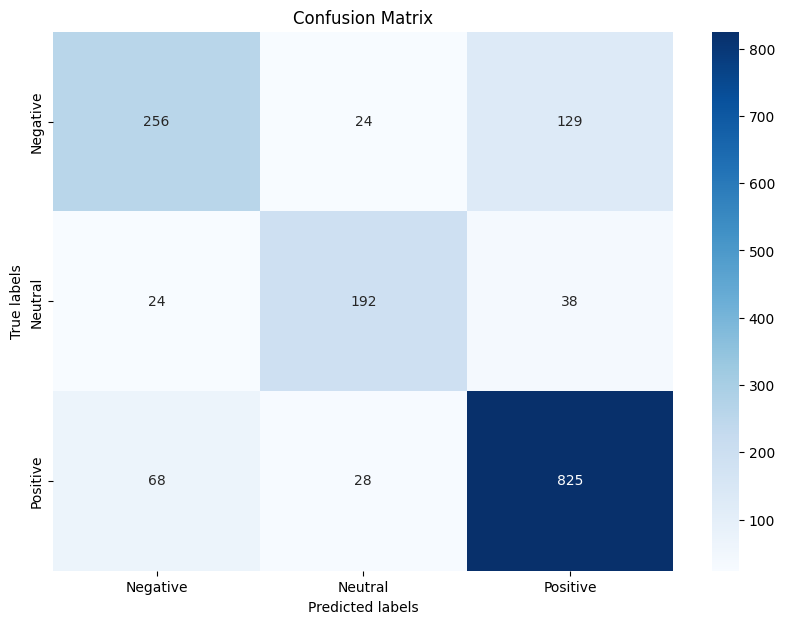

In [ ]:
# Conduct final evaluation on the unseen test dataset
print("\nFinal Evaluation on Test Set:")
cm, report = evaluate_model(model_xlnet, evaluation_dataloader)

# Define class names for the confusion matrix
class_names = ['Negative', 'Neutral', 'Positive']

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')  # Label for the x-axis
plt.ylabel('True labels')  # Label for the y-axis
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Display the plot

In [ ]:
# For Prof -> since we already saved the model weights, dont have to resave if you are testing this code 

# # Save the model's state dictionary
# xlnet_model_save_path = "/content/drive/My Drive/IR Classification/Models/xlnet_model_state.bin"
# torch.save(model_xlnet.state_dict(), xlnet_model_save_path)